# Machine Learning Project 2

In [1]:
# Imports
import pandas as pd
import numpy as np

---
## Generic Functions
Here we define all the functions to be used.

### 1. Data Loading

In [2]:
def load_data(data_path, pos_file, neg_file, size=1_250_000): 

    # positive
    pos = pd.read_table(data_path+pos_file, sep='.\n', names=['tweet'], engine='python')
    pos['label']=1
    print(f"Loaded POS data, correctly interpreted 1-tweet-per-line fashion : {pos.shape[0]==size}")

    # negative
    neg = pd.read_table(data_path+neg_file, sep='.\n', names=['tweet'], engine='python')
    neg['label']=-1
    print(f"Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : {neg.shape[0]==size}")

    # Data sizes
    print(f"Number of tweets : (POS) {pos.shape[0]} (NEG) {neg.shape[0]}\n")

    # Merge datasets to get a complete training set
    tweets = pos.append(neg)
    return tweets

In [3]:
from glove_helper import concatenate

def load_embeddings_and_vocab(embeddings_loc, embeddings_path, vocab_loc, divided=False) :
    
    ## Load word embeddings and vocabulary to compute word vectors of tweets -----------------------------------
    
    # Load word embeddings
    embeddings=None
    if divided : 
        embeddings = concatenate(embeddings_files, embeddings_path)
    else :
        embeddings = np.load(embeddings_path+embeddings_loc)
    print(f'Loaded word embeddings in structure of type {type(embeddings)}.')

    # Loading vocab
    words = pd.read_table(vocab_loc, sep='.\n', names=['word'], engine='python', squeeze=True, na_values=np.nan)
    print(f'Loaded word vocabulary in structure of type {type(words)}.')

    # Check that the vocabulary encompasses all embedded words
    print(f'\nBoth the embeddings and the vocabulary are same length :  {len(embeddings)==words.shape[0]}')
    print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

    ## Clean the data --------------------------------------------------------------------------------------------

    # Drop NaN values in vocab
    nas = words.isna()
    words.dropna(inplace=True)
    # Drop NaN words in embeddings
    embeddings = np.delete(embeddings, nas[nas].index.values, axis=0)
    
    print(f'NaN values were dropped in both tables: {len(embeddings)==words.shape[0]}')
    print(f"Embeddings: {embeddings.shape}, vocab: {words.shape}")

    ## Process data ---------------------------------------------------------------------------------------------
    
    # Index by words for faster index-for-word search
    words = pd.DataFrame(data=words.index, index=words.values)
    embeddings = pd.DataFrame(embeddings, index=words.index)
    
    return embeddings, words

### 2. Data Resampling

In [4]:
from sklearn.utils import resample

def resample_data(data, size, label=1, seed=None) :
    # Get pos and neg datasets
    pos, neg = data.loc[data['label']==label], data.loc[data['label']!=label]
    
    # Get samples balanced by classes
    n = int(size/2)
    pos_ = resample(pos, n_samples=n, replace=False, random_state=seed)
    neg_ = resample(neg, n_samples=n, replace=False, random_state=seed)
    
    # reform dataset
    data_ = pos_.append(neg_)

    return data_

### 3. Data Embedding

In [5]:
def word_vector(tweet, embeddings, embeddings_dim, vocab, agg_func=None):
    """
    Creates the feature vector corresponding to the tweet.
    To do so, computes the mean of the word embeddings corresponding to the vocabulary words in the tweet.
    
    Parameters 
    ----------
    tweet : str
        Input tweet from which the word vector is created.
    """
    split_by_words = tweet.split()
    embed_list = []
    
    # Get words in tweet that are in vocab
    # Get embeddings for these words
    for w in split_by_words:
        if w in vocab.index :
            embed_list.append(  embeddings.loc[w].values  )
            
    if agg_func is None :
        agg_func = lambda x : np.mean(x, axis=0)
    
    # If no vocab word create an empty vector for the tweet
    if not embed_list :
        embed_list = np.zeros((2, embeddings_dim))
        
    result = agg_func(embed_list)
    
    # Be sure to output a list to store in dataframe
    return np.array(result).tolist()

In [6]:
from glove_helper import concatenate

def load_word_vectors(file_path, file_loc, divided=False): 
    # Load pre-computed word vectors file
    precomputed = None
    if divided :
        print('Loading from divided dataset...')
        precomputed = concatenate(word_vectors_files, file_path)
    else : 
        precomputed = np.load(file_path+file_loc, allow_pickle=True)
        
    precomputed = pd.DataFrame(precomputed, columns=['index', 'label', 'mean_embed'])
    print('Successfully loaded from file!')
    
    return precomputed

In [7]:
from project2_helper import isAdmin, parallelize

def compute_word_vectors(data, embeddings, embeddings_dim, vocab, agg_func=None) :
    data = data.copy()
    
    # compute function to run on tweets
    func = lambda t : word_vector(t, embeddings, embeddings_dim, vocab, agg_func=agg_func)
    
    if isAdmin():
        print('Process is run as admin. Running parallelized computation...')
        data['mean_embed']= parallelize(data['tweet'], func)
    else : 
        print('Process is not run as admin. Cannot run parallelized setting, running as sequential...')
        data['mean_embed']= data['tweet'].map(func)

    return data

In [8]:
def save_word_vectors(data, file_path, ending=None):
    
    # Get word vectors information
    word_vectors = data[['label', 'mean_embed']].reset_index()
    dim = len(word_vectors.loc[0, 'mean_embed'])
    
    # Name file to format : path/word_vectors_xxnsamplesxx_xxembeddimxx_ending_npy
    name = file_path + 'word_vectors_' + str(data.shape[0]) + '_' + str(dim)
    # Add ending if requested
    if ending is not None :
        name = name+'_'+str(ending)
    
    # save data
    np.save(name, word_vectors)
    
    return True

### 4. Data Pre-processing

In [9]:
from sklearn.model_selection import train_test_split

def split_dataset(data, test_size=0.25, seed=None) : 

    # Split into training and testing data
    train, test = train_test_split(data, test_size=test_size, random_state=seed)
    print(f"Local training set size : {train.shape[0]}.")
    print(f"Local testing set size : {test.shape[0]}.\n")
     
    # Create features and labels datasets
    xtrain, ytrain = np.array(train.mean_embed.tolist()), np.array(train.label.to_list())
    xtest, ytest = np.array(test.mean_embed.tolist()), np.array(test.label.tolist())

    print(f'Training sample shape: {xtrain.shape[1:]}')
    print(f'Testing sample shape: {xtest.shape[1:]}')
    
    return xtrain, ytrain, xtest, ytest

In [10]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

def preprocess(X) :
    x=X.copy()
    
    ## Standardize data
    # If features are list of features of different sizes, standardization has to be made list-wise
    if len(np.array(x).shape) == 1 : 
        x = np.array([ StandardScaler().fit_transform(a) for a in x ])
    else :
        x = StandardScaler().fit_transform(x)
    
    ## TODO Polynomial features and interactions
    
    ## other data preprocessing
    
    return x

### 5. Generate submission

In [11]:
# To format the testing data
def extract_tweet(tweet):
    return tweet.split(",", 1)[1]

In [12]:
def get_test_data(data_path, test_file='test_data.txt') :
    # Load the testing data
    test = pd.read_fwf(data_path+test_file, sep="\n", header=None)
    test = test.rename(columns={0:'tweet', 1:'na1', 2:'na2'})

    # Reformating it for submission
    test.index = test.index+1 # Format asked by AI Crowd
    test = test['tweet'].map(extract_tweet).to_frame()

    return test

In [13]:
# Creating submission file
import csv
def create_csv_submission(ids, y_pred, name):
    """
    Creates an output file in csv format for submission to kaggle
    Arguments: ids (event ids associated with each prediction)
               y_pred (predicted class labels)
               name (string name of .csv output file to be created)
    """
    with open(name, 'w', newline='') as csvfile:
        fieldnames = ['Id', 'Prediction']
        writer = csv.DictWriter(csvfile, delimiter=",", fieldnames=fieldnames)
        writer.writeheader()
        for r1, r2 in zip(ids, y_pred):
            writer.writerow({'Id':int(r1),'Prediction':int(r2)})

In [14]:
# Base parameters

### Loading
data_path = '../data/'
pos_data = 'train_pos_full.txt'
neg_data = 'train_neg_full.txt'

precomputed_path = '../precomputed_data/'
embeddings_file = 'embeddings_full_10epoch_100dim.npy'
vocab_loc = '../data/vocab_cut.txt'

embeddings_dim_info = 100
data_size = 100_000

word_vectors_files = ['word_vectors_100000_100_part1.npy',
                     'word_vectors_100000_100_part2.npy']
divided_word_vectors = True

---
## Data pre-training

In [15]:
# Load data
tweets = load_data(data_path, pos_data, neg_data)
embeddings, vocab = load_embeddings_and_vocab(embeddings_file, precomputed_path, vocab_loc)

# Resample data
tweets_ = resample_data(tweets, data_size, seed=1)

Loaded POS data, correctly interpreted 1-tweet-per-line fashion : True
Loaded NEG data, correctly interpreted 1-tweet-per-line fashion : True
Number of tweets : (POS) 1250000 (NEG) 1250000

Loaded word embeddings in structure of type <class 'numpy.ndarray'>.
Loaded word vocabulary in structure of type <class 'pandas.core.series.Series'>.

Both the embeddings and the vocabulary are same length :  True
Embeddings: (101298, 100), vocab: (101298,)
NaN values were dropped in both tables: True
Embeddings: (101296, 100), vocab: (101296,)


In [17]:
# Load word vectors
tweets_ = load_word_vectors(
    precomputed_path, 
    word_vectors_files, 
    divided=divided_word_vectors)

# Useless here (for demonstration purposes in case of computation and not loading)
save_word_vectors(tweets_, precomputed_path)

Loading from divided dataset...
Successfully loaded from file!


True

In [18]:
# Train-test split data
xtrain_, ytrain_, xtest_, ytest_ = split_dataset(tweets_)

# Pre-process training set
xtrain_ = preprocess(xtrain_)
xtest_ = preprocess(xtest_)

Local training set size : 75000.
Local testing set size : 25000.

Training sample shape: (100,)
Testing sample shape: (100,)


In [19]:
# Importing functions to estimate model efficiency
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

### Models Training
* Linear Regression
* Logistic Regression
* SVM
* Neural Networks

In [21]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

classifiers = dict()

In [22]:
%%time
#### BASELINE : Neural Networks

# Neural Network
name = 'Neural Network'

nn_classifier = MLPClassifier().fit(xtrain_,ytrain_)
score = nn_classifier.score(xtest_,ytest_)

classifiers[name] = (nn_classifier, score)

print(f"R2 score for {name} classifier is {score}.")

R2 score for Neural Network classifier is 0.60532.
Wall time: 3min 19s


C:\Users\Nico\.conda\envs\ada\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [23]:
# Compute predictions
predtest_ = nn_classifier.predict(xtest_)

metrics = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5, output_dict=True)
report = classification_report(ytest_, predtest_, labels=[1,-1], target_names=['pos', 'neg'], digits=5)
print(report)

              precision    recall  f1-score   support

         pos    0.59925   0.66659   0.63113     12663
         neg    0.61316   0.54243   0.57563     12337

    accuracy                        0.60532     25000
   macro avg    0.60620   0.60451   0.60338     25000
weighted avg    0.60611   0.60532   0.60374     25000



In [195]:
# Save baseline results
path = '../results/'
name = path+'metrics_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'_baseline'
np.save(name, metrics)

---
### Custom models
Let us implement a custom model following the paper $\text{Text Classification with Deep Neural Networks}$ by *Maaz Amajd et al.* from Microsoft.

In [16]:
# Base parameters

### Loading
data_path = '../data/'
pos_data = 'train_pos_full.txt'
neg_data = 'train_neg_full.txt'

precomputed_path = '../precomputed_data/'
embeddings_file = 'embeddings_full_10epoch_100dim.npy'
vocab_loc = '../data/vocab_cut.txt'

embeddings_dim_info = 100
data_size = 100_000

word_vectors_file = 'word_vectors_100000_12_cnn.npy'
divided_word_vectors = True
seed = 1

#### Recompute word vectors datasets
The convolutionnal Neural Network uses a matrix as input format. Here we use a matrix of words vectors representing the tweet.

In [17]:
%%time
# Resample tweets for cnn
tweets_cnn = resample_data(tweets, data_size, seed=seed)

# Compute matrices of word embeddings for tweets
#tweets_cnn = compute_word_vectors(tweets_cnn, embeddings, embeddings_dim_info, vocab, agg_func=(lambda _ : _))
tweets_cnn = load_word_vectors(precomputed_path, word_vectors_file)

Successfully loaded from file!
Wall time: 49.1 s


In [21]:
# Save computed word embeddings matrices 
save_word_vectors(tweets_cnn, precomputed_path, ending='cnn')

True

In [18]:
# Train test split data
xtrain_cnn, ytrain_cnn, xtest_cnn, ytest_cnn = split_dataset(tweets_cnn, seed=seed)

Local training set size : 75000.
Local testing set size : 25000.



<ipython-input-9-288999fe21b1>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  xtrain, ytrain = np.array(train.mean_embed.tolist()), np.array(train.label.to_list())


Training sample shape: ()
Testing sample shape: ()


<ipython-input-9-288999fe21b1>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  xtest, ytest = np.array(test.mean_embed.tolist()), np.array(test.label.tolist())


In [19]:
# Preprocess datasets
xtrain_cnn = preprocess(xtrain_cnn)
xtest_cnn = preprocess(xtest_cnn)

<ipython-input-10-415d7496b1fe>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array([ StandardScaler().fit_transform(a) for a in x ])
<ipython-input-10-415d7496b1fe>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = np.array([ StandardScaler().fit_transform(a) for a in x ])


In [36]:
def reshape_tweet_matrices(tweets, embed_dim, words_per_tweet) : 
    # may have to change shape to (w, e, 1)
    result = [np.resize(t, (words_per_tweet, embed_dim)).tolist() for t in tweets]
    return result

In [33]:
xtrain_cnn = reshape_tweet_matrices(xtrain_cnn, embeddings_dim_info, 15)

In [38]:
xtrain_cnn = np.array(xtrain_cnn)

In [101]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

# Define base parameters for the CNN

batch_size = 64 ## TODO tune batch size (depends on mem)
epochs = 20
num_classes = 2
n_filters = 100
kernel_size = (3, 3)
dense_units = 250

In [104]:
# Create the layers of the CNN
cnn_classifier = Sequential()
cnn_classifier.add(Conv2D(n_filters, kernel_size=kernel_size, activation='relu',input_shape=(15, embeddings_dim_info, 1), padding='same'))
cnn_classifier.add(LeakyReLU(alpha=0.1))
cnn_classifier.add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_classifier.add(Flatten())
cnn_classifier.add(Dense(dense_units, activation='relu'))
#cnn_classifier.add(LeakyReLU(alpha=0.1))                  
cnn_classifier.add(Dense(num_classes, activation='sigmoid'))

cnn_classifier.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
cnn_classifier.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 15, 100, 100)      1000      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 15, 100, 100)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 50, 100)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 250)               10000250  
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 502       
Total params: 10,001,752
Trainable params: 10,001,752
Non-trainable params: 0
__________________________________________

In [68]:
ytrain_cnn.resize((75000, 1))

In [90]:
from keras.utils import to_categorical

ytrain_cnn = np.array([ 0 if x==-1 else x for x in ytrain_cnn ])
ytrain_cnn = to_categorical(ytrain_cnn)
ytrain_cnn

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
%%time
# Train the model
cnn_history = cnn_classifier.fit(xtrain_cnn, ytrain_cnn, batch_size=batch_size,epochs=epochs,verbose=1, validation_split=0.2)

In [50]:
# Reshape test data
xtest_cnn = reshape_tweet_matrices(xtest_cnn, embeddings_dim_info, 15)

In [56]:
xtest_cnn = np.array(xtest_cnn)
xtest_cnn.resize((25000, 15, 100, 1))
xtest_cnn.shape

(25000, 15, 100, 1)

In [97]:
ytest_cnn = np.array([ 0 if x==-1 else x for x in ytest_cnn ])
ytest_cnn = to_categorical(ytest_cnn)
ytest_cnn

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [98]:
# Evaluate Model
test_eval = cnn_classifier.evaluate(xtest_cnn, ytest_cnn)

782/782 [==============================] - 19s 24ms/step - loss: 1.6181 - accuracy: 0.6066


In [99]:
test_eval

[1.6181174516677856, 0.6065999865531921]

In [ ]:
epochs = 20
num_classes = 2
dense_units = 250

results = dict()

for ks in [3,4,5] :
    for bs in [32,64,128] :
        for fs in [100, 200, 300] :
            print(f"kernelsize {ks}, batchsize {bs}, filtersize={fs}")
            
            # Create the layers of the CNN
            cnn_classifier = Sequential()
            cnn_classifier.add(Conv2D(fs, kernel_size=(ks,ks), activation='relu',input_shape=(15, embeddings_dim_info, 1), padding='same'))
            #cnn_classifier.add(LeakyReLU(alpha=0.1))
            cnn_classifier.add(MaxPooling2D(pool_size=(2,2), padding='same'))
            cnn_classifier.add(Flatten())
            cnn_classifier.add(Dense(dense_units, activation='relu'))
            #cnn_classifier.add(LeakyReLU(alpha=0.1))                  
            cnn_classifier.add(Dense(num_classes, activation='sigmoid'))

            cnn_classifier.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
            print(cnn_classifier.summary())

            # Train the model
            cnn_history = cnn_classifier.fit(xtrain_cnn, ytrain_cnn, batch_size=bs,epochs=epochs,verbose=1, validation_split=0.2)

            # Evaluate Model
            test_eval = cnn_classifier.evaluate(xtest_cnn, ytest_cnn)
            
            results[(ks,bs,fs)] = (cnn_history, test_eval)

kernelsize 3, batchsize 32, filtersize=100
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 15, 100, 100)      1000      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 50, 100)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 250)               10000250  
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 502       
Total params: 10,001,752
Trainable params: 10,001,752
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
1875/1875 [==============================] - 269

In [ ]:
# Save CNN results
path = '../results/'
name = path+'metrics_'+str(local_t_size)+'_'+str(embeddings_dim_info)+'_CNN'
np.save(name, metrics)

---
## Testing
This section is dedicated to using the previous classifiers to predict the labels of the provided testing set.

,index,label,mean_embed
0,1193381,1,"[0.032002123948292126, -0.014642657203437489, ..."
1,644929,1,"[0.10238272539678156, -0.02736877932503185, 0...."
2,578303,1,"[0.032941437860502285, 0.0014634508830161917, ..."
3,525309,1,"[0.04879550502681794, 0.017707842326910788, 0...."
4,34941,1,"[0.1420258276670681, -0.03843481256309387, 0.0..."
...,...,...,...
99995,1159713,-1,"[0.15079636217861106, 0.005626630631020118, 0...."
99996,249113,-1,"[0.05451928253254213, -0.052474023026710545, 0..."
99997,913236,-1,"[0.09112505455684311, 0.040824608634503316, 0...."
99998,830941,-1,"[0.12102069953544096, -0.047875157832210066, 0..."


In [37]:
test = get_test_data('../data/')
test = compute_word_vectors(test, embeddings, 100, vocab)
xtest = preprocess(test.mean_embed.tolist())

model = classifiers['Neural Network'][0]
predictions = model.predict(xtest)
create_csv_submission(test.index, predictions, '../submission/submission.csv')

Process is not run as admin. Cannot run parallelized setting, running as sequential...


<ipython-input-36-415d7496b1fe>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if len(np.array(x).shape) == 1 :


ValueError: Expected 2D array, got scalar array instead:
array=-0.009954323422670053.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [199]:
# Recalling classifiers 
# stored in format : 'classifier name'=(classifier, R2 score) 

print(f"Models computed so far are the following.\n ")
print(f"{'Classifier':50s} | {'R2 Score':20s}")
print(f"-----------------------------------------------------------------")
for k,v in classifiers.items() :
    print(f"{k:50s} | {v[1]:10.10f}")
print('\n')

Models computed so far are the following.
 
Classifier                                         | R2 Score            
-----------------------------------------------------------------
Linear Model                                       | 0.0528607913
Logistic Regression                                | 0.5927200000
Logistic Regression using cross-validation         | 0.5928000000
SVM classifier                                     | 0.5940400000
Neural Network                                     | 0.6162800000




## Results
Here we detail previously computed results from `results/` folder.

### GloVe Dimensions evolution
Below we detail how different metrics perform when the dimension of the word embeddings computed by GloVe algorithm changes.

In [213]:
accs = []
precs = []
recs = []
f1s = []


for d in [20,50,100,250] :
    print(f'\n{d} dimensions\n')
    name = path+'metrics_'+str(local_t_size)+'_'+str(d)+'_baseline.npy'
    r = np.load(name, allow_pickle=True)
    r = r.item()
    print(f"Accuracy : {r['accuracy']}")
    print(f"{'Label':10s} | {'precision':10s} | {'recall':10s} | {'f1-score':10s}")
    print(f"{'pos':10s} | {r['pos']['precision']:10f} | {r['pos']['recall']:10f} | {r['pos']['f1-score']:10f}")    
    print(f"{'neg':10s} | {r['neg']['precision']:10f} | {r['neg']['recall']:10f} | {r['neg']['f1-score']:10f}")  
    accs.append(r['accuracy'])
    precs.append(r['pos']['precision'])
    recs.append(r['pos']['recall'])
    f1s.append(r['pos']['f1-score'])


20 dimensions

Accuracy : 0.585
Label      | precision  | recall     | f1-score  
pos        |   0.574874 |   0.671121 |   0.619280
neg        |   0.599399 |   0.497868 |   0.543936

50 dimensions

Accuracy : 0.5896
Label      | precision  | recall     | f1-score  
pos        |   0.575301 |   0.671701 |   0.619775
neg        |   0.609460 |   0.508167 |   0.554223

100 dimensions

Accuracy : 0.60904
Label      | precision  | recall     | f1-score  
pos        |   0.587911 |   0.726698 |   0.649979
neg        |   0.643141 |   0.491608 |   0.557257

250 dimensions

Accuracy : 0.61628
Label      | precision  | recall     | f1-score  
pos        |   0.634955 |   0.542312 |   0.584988
neg        |   0.602425 |   0.689859 |   0.643184


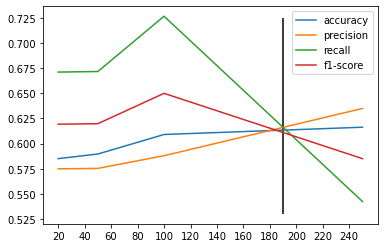

In [236]:
import matplotlib.pyplot as plt
x = [20,50,100,250]
plt.plot(x, accs)
plt.plot(x, precs)
plt.plot(x, recs)
plt.plot(x, f1s)
plt.legend(['accuracy','precision','recall','f1-score'])
plt.xticks(ticks=np.arange(0,260,20))
plt.vlines(190,ymin=0.53, ymax=0.725, color='black')
name = '../plots/'+'metrics_'+str(local_t_size)+'_dims_baseline.png'
plt.savefig(name, dpi=1000)
plt.show()


We note that the optimal number of dimensions seems to lie around **190** as the parameters are at their common highest at this point.